In [70]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import io
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
%matplotlib inline

# Configure things here
Amberdata_API_KEY = 'YOUR_API_KEY'
start_date = "2019-01-20"
end_date = "2020-05-09"

# Call Amberdata's API
def amberdata(url, queryString, apiKey):
    try:
        headers = {'x-api-key': apiKey}
        response = requests.request("GET", url, headers=headers, params=queryString)
        return response.text
    except Exception as e:
        raise e

# Get Market data from Amberdata
def amberdata_ohlcv(exchange, symbol, startDate, endDate):
    format = "%Y-%m-%dT%H:%M:%S"
    startTimestamp = datetime.strptime(startDate, '%Y-%m-%d')
    endTimestamp = datetime.strptime(endDate, '%Y-%m-%d')

    current = startTimestamp
    next = current
    fields = "timestamp,open,high,low,close,volume"
    payload = fields
    while (current < endTimestamp):
        next += relativedelta(years=1)
        if (next > endTimestamp):
            next = endTimestamp
        print('Retrieving OHLCV between', current, ' and ', next)
        result = amberdata(
            "https://web3api.io/api/v2/market/ohlcv/" + symbol + "/historical",
            {"exchange": exchange, "timeInterval": "days", "timeFormat": "iso", "format": "raw_csv", "fields": fields, "startDate": current.strftime(format), "endDate": next.strftime(format)},
            Amberdata_API_KEY
        )
        payload += "\n" + result
        current = next

    return payload

# Get On-chain data from Amberdata - Stock to flow valuation model
def amberdata_stf(symbol, startDate, endDate):
    print('Retrieving STF between', startDate, ' and ', endDate)
    return amberdata(
        "https://web3api.io/api/v2/market/metrics/" + symbol + "/valuations/historical",
        {"format": "csv", "timeFrame": "day", "startDate": startDate, "endDate": endDate},
        Amberdata_API_KEY
    )

# Get On-chain data from Amberdata - NVT Signal
def amberdata_nvts(symbol, startDate, endDate):
    print('Retrieving NVT Signal between', startDate, ' and ', endDate)
    return amberdata(
        "https://web3api.io/api/v2/market/metrics/" + symbol + "/historical/nvt",
        {"format": "csv", "timeFrame": "day", "startDate": startDate, "endDate": endDate},
        Amberdata_API_KEY
    )


def to_pandas(csv):
    return pd.read_csv(io.StringIO(csv), index_col='timestamp', parse_dates=True)

In [50]:
btc = to_pandas(amberdata_ohlcv("gdax", "btc_usd", start_date, end_date))
btc_stf = to_pandas(amberdata_stf("btc", start_date, end_date))
#btc_nvts = to_pandas(amberdata_nvts("btc", start_date, end_date))

Retrieving OHLCV between 2019-01-20 00:00:00  and  2020-01-20 00:00:00
Retrieving OHLCV between 2020-01-20 00:00:00  and  2020-05-09 00:00:00
Retrieving STF between 2019-01-20  and  2020-05-09


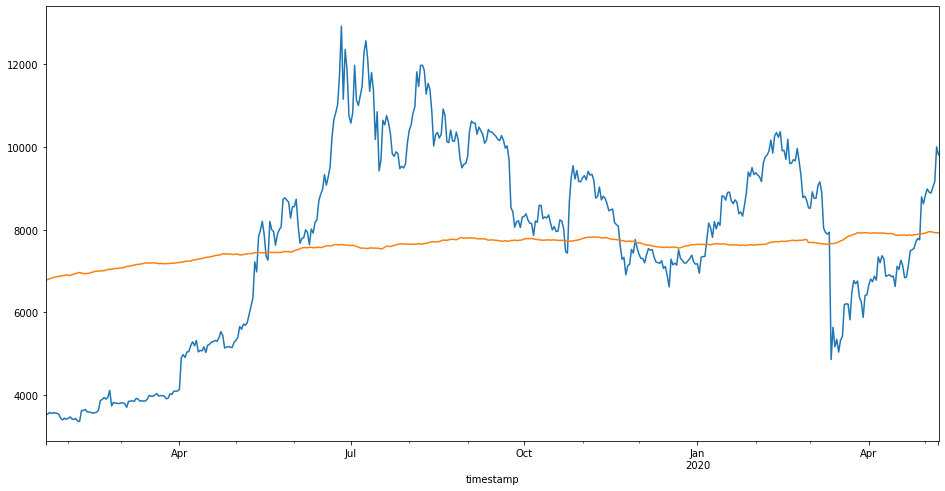

In [78]:
btc['close'].plot(figsize=(16,8))
btc_stf['stockToFlow_price'].plot()